## Main idea
In Interactive Broker(IB) there is a new service that allow user to predict event outcome called ForecastTrader. These Forecast Contract might share the same underlying with traditional option, one such eample is:

Will [expiration] CME E-mini S&P 500 Index Futures settle above $6,050 on February 14 2025?

User can buy the 'Yes' or 'No' outcome, and when the event concluded the correct side will be paid and the wrong side would lose all the bet.
The price of each outcome range from $[0,1]\$$ and the correct side would be paid $\$1$ for each contract.

## Task
Can we construct a risk-free (almost always)positive payout portfolio using these contract and other financial tools?

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import seaborn as sns

# Create the animation (in a Jupyter notebook)
from IPython.display import HTML

import numpy as np
import pandas as pd

from scipy import stats

In a general case, the call and binary put could have different maturity and strike price:

$C(S(t),K_\mathrm{Vanilla},T_\mathrm{Vanilla})$ and $P(F(S(t),t),T_\mathrm{Binary},T_\mathrm{Binary})$

where $F(S(t),t)$ is the future of $S(t)$

# Payoff
At maturity, the options pays:
$$
C_{T_\mathrm{Vanilla}} = \mathrm{max}(S(T_\mathrm{Vanilla})-K_\mathrm{Vanilla}, 0)
$$

$$
P_{T_{Binary}} = 1 \ \mathrm{if} \ F(S(T_\mathrm{Vanilla})) < T_\mathrm{Binary} \ \mathrm{else} \ 0
$$

In [8]:
def Vanilla_payoff(S, K, option_type='call'):
    if option_type == 'call':
        return np.maximum(S-K, 0)
    else: 
        return np.maximum(K-S, 0)

def Binary_payoff(F, K, option_type='put'):
    if option_type == 'call':
        return 1 if K<F else 0
    else:
        return 1 if K>F else 0

Now we construct a Portfolio by long call and put
$$
\Pi_t = V_t + N * B_t.
$$
where $N$ is some constant.

So the PnL over time is just 
$$
\mathrm{PnL}_t = V_t - V_0 + + N*(B_t  - B_0).
$$

We will use a fair price for modelling the future
$$
F(S(t),t) = e^{r \tau}S(t),
$$
where $\tau = T_\mathrm{future}-t $ and it is guarantee that $T_\mathrm{future} \geq T_Vanilla$ in order for the bet to make sense.

In [13]:
def Future(S,r,tau):
    return np.exp(r*tau)*S if tau>=0 else S

Using this, we can estimate the optimal $T_\mathrm{Binary}$ such that the payoff can cover the price of the option. We want to match the effective strike
$$
K_\mathrm{Vanilla} = e^{-r (T-T_\mathrm{Vanilla})} T_\mathrm{Binary},
$$
such that the payoff from put can cover the cost of the call for most of the range of S.
So
$$
N = \frac{V_0}{1-B_0}
$$


As T_Binary is fixed by IB, we should choose the call option with strike 
$$
K_Vanilla \approx e^{-r (T-T_Vanilla)} T_Binary
$$

## Testing the PnL functions

# Option model
We will use Black-Schole for both vanilla and binary options, although the price path might not be accurate but the final payoff should be.

In [19]:
def Vanilla_options(S, K, T, r, sigma, q=0, option_type='call'):
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return option_price

In [21]:
def Binary_options(S, K, T, r, sigma, q=0, option_type='put'):
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = np.exp(-r * T) * norm.cdf(-d2)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return option_price

Now we shell test different scenario, for S&P 500 option the ticker for option is(usually) $\$5$ and we will use $T_Binary = 6050$.

Although S&P 500 options are written with maturity spending every trading day, we want to keep it general and explore mismatch $T_Vanilla$ and $T_Vanilla$.

In [45]:
def Find_K_C(T_Binary, T_Vanilla, T_future, r=0.00): # Round to closest number ending with 5
    K_Vanilla = np.exp(-r*(T_future-T_Vanilla))*T_Binary
    return round(K_Vanilla / 5) * 5

In [47]:
def Initialize(S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, r= 0.04):
    K_Vanilla = Find_K_C(K_Binary, T_Binary, T_future, r)
    V_0 = Vanilla_options(S_0, K_Vanilla, T_Vanilla, r, sigma)
    B_0 = Binary_options(S_0, K_Binary, T_Binary, r, sigma)
    N = int(V_0/(1-B_0))
    return {
        'K_Vanilla': K_Vanilla,
        'V_0': V_0,
        'B_0': B_0,
        'N': N
    }

def Portfolio_t(t, S_t, K_Vanilla, K_Binary, T_Binary, T_Vanilla, T_future, sigma, N, r=0.04):
    assert T_future > T_Binary
    if t <  T_Vanilla:
        C = Vanilla_options(S_t, K_Vanilla, T_Vanilla-t, r, sigma)
    else:
        C = Vanilla_payoff(S_t, K_Vanilla)
    F = Future(S_t,r,T_future-t)
    if t < T_Binary:
        P = Binary_options(F, K_Binary, T_Binary-t, r, sigma)
    else:
        P = Binary_payoff(F, K_Binary)
    return C + N*P

In [99]:
def Final_PnL(S_t, S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, Final_time):
    in_para=Initialize(S_0=S_0, K_Binary=K_Binary, T_Binary=T_Binary, T_Vanilla=T_Vanilla, T_future=T_future, sigma=sigma)
    K_Vanilla = in_para['K_Vanilla']
    V_0 = in_para['V_0']
    B_0 = in_para['B_0']
    N = in_para['N']

    return Portfolio_t(Final_time, S_t, K_Vanilla, K_Binary, T_Binary, T_Vanilla, T_future, sigma, N) - V_0 - B_0

In [141]:
def analyze_option_scenarios(S_0, K_Binary, sigma, r=0.04):
    T_future = 300/252  # 150 days to future expiry
    Final_time = T_future  # Evaluate at future expiry

    # Case 1: T_Binary > T_Vanilla
    T_P_1 = 120/252  # Binary option expires in 120 days
    T_C_1 = 90/252   # Vanilla call expires in 90days

    # Case 2: T_Vanilla > T_Binary
    T_P_2 = 90/252   # Binary option expires in 90 days
    T_C_2 = 120/252  # Vanilla call expires in 120 days

    # Case 3: T_Vanilla = T_Binary
    T_P_3 = 90/252
    T_C_3 = 90/252 
    

    price_range = np.linspace(5500, 6500, 1001)

    PnL_range_case1 = []
    PnL_range_case2 = []
    PnL_range_case3 = []

    for S in price_range:
        PnL_case1 = Final_PnL(S, S_0, K_Binary, T_P_1, T_C_1, T_future, sigma, Final_time)
        PnL_range_case1.append(PnL_case1)
        
        PnL_case2 = Final_PnL(S, S_0, K_Binary, T_P_2, T_C_2, T_future, sigma, Final_time)
        PnL_range_case2.append(PnL_case2)

        PnL_case3 = Final_PnL(S, S_0, K_Binary, T_P_3, T_C_3, T_future, sigma, Final_time)
        PnL_range_case3.append(PnL_case3)

    plt.figure(figsize=(12,6))
    plt.plot(price_range, PnL_range_case1, label = r'T_Binary > T_Vanilla')
    plt.plot(price_range, PnL_range_case2, label = r'T_Binary < T_Vanilla')
    plt.plot(price_range, PnL_range_case3, label = r'T_Binary = T_Vanilla')
    plt.axhline(y=0, linestyle = '--', color='r')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    # Return results without plotting
    return {
        'price_range': price_range,
        'PnL_TPC': PnL_range_case1,  # T_Binary > T_Vanilla case
        'PnL_TCP': PnL_range_case2,  # T_Vanilla > T_Binary case
        'parameters': {
            'S_0': S_0,
            'K_Binary': K_Binary,
            'T_P_1': T_P_1,
            'T_C_1': T_C_1,
            'T_P_2': T_P_2,
            'T_C_2': T_C_2,
            'T_future': T_future,
            'sigma': sigma,
            'r': r
        }
    }

# Let try some random paramter

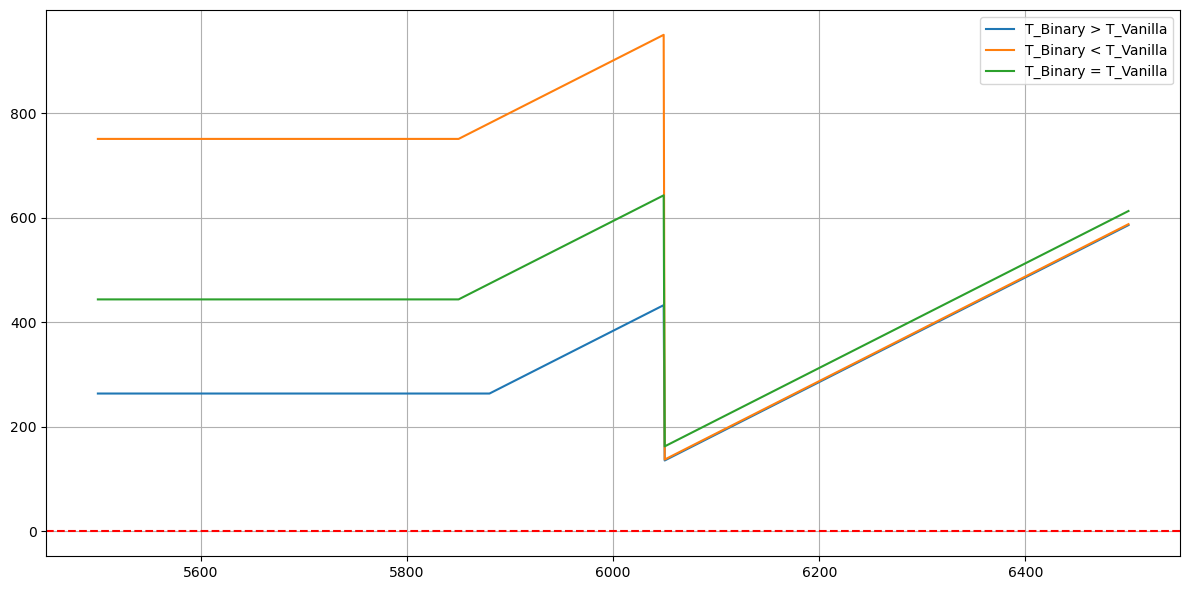

In [144]:
PnL_final = analyze_option_scenarios(5000, 6050, 0.20)

### It seems risk free but is it really?

# MC sim

In [68]:
def Monte_Carlo_PnL_Distribution(S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, r=0.04, num_paths=1000, num_steps=252):
    init_params = Initialize(S_0=S_0, K_Binary=K_Binary, T_Binary=T_Binary, T_Vanilla=T_Vanilla, T_future=T_future, sigma=sigma, r=r)
    K_Vanilla = init_params['K_Vanilla']
    V_0 = init_params['V_0']
    B_0 = init_params['B_0']
    N = init_params['N']
    
    # Initial cost
    Cost = V_0 + N * B_0
    
    # Time grid - convert years to trading days
    trading_days_per_year = 252
    total_days = int(T_future * trading_days_per_year)
    
    # We need the price for each trading day
    days = np.arange(total_days + 1)  # 0 to total_days inclusive
    dt = 1/trading_days_per_year  # Time step of one trading day
    times = days / trading_days_per_year  # Convert days to years for calculations
    
    S = np.zeros((num_paths, total_days + 1))
    S[:, 0] = S_0
    
    # Also initialize array for PnL over time
    pnl_over_time = np.zeros((num_paths, total_days + 1))
    
    # Generate stock price paths using GBM
    for t in range(1, total_days + 1):
        Z = np.random.normal(0, 1, num_paths)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # Store portfolio values after both options expire
    post_expiry_values = np.zeros(num_paths)
    latest_expiry = max(T_Vanilla, T_Binary)
    latest_expiry_idx = int(latest_expiry * trading_days_per_year)
    
    # Calculate PnL for each path at each time step
    for t in range(total_days + 1):
        current_time = times[t]
        for i in range(num_paths):
            # For the period before both options expire
            if current_time <= latest_expiry:
                # Calculate portfolio value normally
                portfolio_value = Portfolio_t(current_time, S[i, t], K_Vanilla, K_Binary, T_Binary, T_Vanilla, T_future, sigma, N, r)
                pnl_over_time[i, t] = portfolio_value - Cost
                
                # If we're at the latest expiry point, store the portfolio value for future use
                if t == latest_expiry_idx:
                    post_expiry_values[i] = portfolio_value
            else:
                # After both options expire, use the stored value from expiry
                pnl_over_time[i, t] = post_expiry_values[i] - Cost
    
    # Select a few sample paths for visualization
    sample_paths_indices = np.random.choice(num_paths, min(10, num_paths), replace=False)
    sample_paths = S[sample_paths_indices, :]
    sample_pnl_paths = pnl_over_time[sample_paths_indices, :]
    
    # Calculate statistics for the final PnL
    final_pnl = pnl_over_time[:, -1]
    
    # Calculate average PnL across all paths at each time step
    avg_pnl_over_time = np.mean(pnl_over_time, axis=0)
    
    # Calculate percentiles of PnL across all paths at each time step
    percentile_low_time = np.percentile(pnl_over_time, 2.5, axis=0)
    percentile_high_time = np.percentile(pnl_over_time, 97.5, axis=0)
    
    return {
        'final_pnl': final_pnl,
        'S_final': S[:, -1],
        'sample_paths': sample_paths,
        'sample_pnl_paths': sample_pnl_paths,
        'days': days,
        'all_stock_paths': S,
        'pnl_over_time': pnl_over_time,
        'avg_pnl_over_time': avg_pnl_over_time,
        'percentile_low_time': percentile_low_time,
        'percentile_high_time': percentile_high_time,
        'statistics': {
            'mean_pnl': np.mean(final_pnl),
            'std_pnl': np.std(final_pnl),
            'median_pnl': np.median(final_pnl),
            'min_pnl': np.min(final_pnl),
            'max_pnl': np.max(final_pnl),
            'percentile_5': np.percentile(final_pnl, 5),
            'percentile_95': np.percentile(final_pnl, 95)
        },
        'parameters':{
            'K_Binary': K_Binary,
            'K_Vanilla': K_Vanilla,
            'T_Binary': T_Binary,
            'T_Vanilla': T_Vanilla,
            'T_future': T_future
        }
        }

def plot_mc_results(mc_results, title="Monte Carlo Simulation Results"):
    K_Binary = mc_results['parameters']['K_Binary']
    K_Vanilla = mc_results['parameters']['K_Vanilla']
    T_Binary = mc_results['parameters']['T_Binary']
    T_Vanilla = mc_results['parameters']['T_Vanilla']
    
    # Get the last option maturity
    latest_maturity = max(T_Binary, T_Vanilla)
    latest_maturity_day = int(latest_maturity * 252)
    
    # Calculate average stock price and confidence bands across all paths
    all_paths = mc_results['pnl_over_time'].shape[0]  # Total number of paths
    all_stock_paths = np.zeros((all_paths, len(mc_results['days'])))
    
    # If we already have all stock paths, use them, otherwise extract from sample
    if 'all_stock_paths' in mc_results:
        all_stock_paths = mc_results['all_stock_paths']
    else:
        # Just use sample paths as a fallback
        all_stock_paths = mc_results['sample_paths']
    
    # Calculate statistics for stock price paths
    avg_stock_price = np.mean(all_stock_paths, axis=0)
    stock_price_low = np.percentile(all_stock_paths, 2.5, axis=0)
    stock_price_high = np.percentile(all_stock_paths, 97.5, axis=0)
    
    # Plot 1: Sample Stock Price Paths with confidence bands
    plt.figure(figsize=(12, 6))
    for i in range(mc_results['sample_paths'].shape[0]):
        plt.plot(mc_results['days'], mc_results['sample_paths'][i, :], alpha=0.5)
    
    # Add average stock price and confidence bands
    plt.plot(mc_results['days'], avg_stock_price, 'k--', linewidth=2, label='Average Stock Price')
    plt.fill_between(mc_results['days'], 
                    stock_price_low, 
                    stock_price_high,
                    alpha=0.2, color='gray', label='95% Confidence Band')
    
    # Mark option expiry days
    T_Binary_day = int(T_Binary * 252)
    T_Vanilla_day = int(T_Vanilla * 252)
    if T_Binary_day <= max(mc_results['days']):
        plt.axvline(x=T_Binary_day, color='g', linestyle='--', label=f'Binary Option Expiry (Day {T_Binary_day})')
    if T_Vanilla_day <= max(mc_results['days']):
        plt.axvline(x=T_Vanilla_day, color='r', linestyle='--', label=f'Vanilla Option Expiry (Day {T_Vanilla_day})')

    plt.axhline(y=K_Vanilla, color='r', linestyle='--', label=f'Vanilla Option strike {K_Vanilla}')
    plt.axhline(y=K_Binary, color='g', linestyle='--', label=f'Binary Option strike {K_Binary}')
    
    plt.title('Stock Price Paths with Diffusion Band')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Sample PnL Paths over time
    plt.figure(figsize=(12, 6))
    for i in range(mc_results['sample_pnl_paths'].shape[0]):
        plt.plot(mc_results['days'], mc_results['sample_pnl_paths'][i, :], alpha=0.5)
    
    # Add average PnL and confidence bands
    plt.plot(mc_results['days'], mc_results['avg_pnl_over_time'], 'k--', linewidth=2, label='Average PnL')
    plt.fill_between(mc_results['days'], 
                    mc_results['percentile_low_time'], 
                    mc_results['percentile_high_time'],
                    alpha=0.2, color='gray', label='95% Confidence Band')
    
    # Mark option expiry days
    if T_Binary_day <= max(mc_results['days']):
        plt.axvline(x=T_Binary_day, color='g', linestyle='--', label=f'Binary Option Expiry (Day {T_Binary_day})')
    if T_Vanilla_day <= max(mc_results['days']):
        plt.axvline(x=T_Vanilla_day, color='r', linestyle='--', label=f'Vanilla Option Expiry (Day {T_Vanilla_day})')
    
    plt.title('PnL Evolution Over Time')
    plt.xlabel('Trading Days')
    plt.ylabel('PnL')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: Stock Price Distribution at Last Option Maturity
    plt.figure(figsize=(12, 6))
    
    # Get the stock prices at the last option maturity
    if latest_maturity_day < len(mc_results['days']):
        stock_prices_at_maturity = all_stock_paths[:, latest_maturity_day]
        
        # Calculate statistics
        mean_price = np.mean(stock_prices_at_maturity)
        median_price = np.median(stock_prices_at_maturity)
        percentile_5 = np.percentile(stock_prices_at_maturity, 5)
        percentile_95 = np.percentile(stock_prices_at_maturity, 95)
        
        # Create histogram
        plt.hist(stock_prices_at_maturity, bins=50, density=True, alpha=0.7)
        plt.axvline(mean_price, color='r', linestyle='--', 
                    label=f"Mean Price: {mean_price:.2f}")
        plt.axvline(median_price, color='b', linestyle='--', 
                    label=f"Median Price: {median_price:.2f}")
        plt.axvline(percentile_5, color='g', linestyle='--', 
                    label=f"5th Percentile: {percentile_5:.2f}")
        plt.axvline(percentile_95, color='g', linestyle='--', 
                    label=f"95th Percentile: {percentile_95:.2f}")
        
        # Add option strikes for reference
        plt.axvline(K_Binary, color='g', linestyle='-', 
                    label=f"Binary Strike: {K_Binary}")
        plt.axvline(K_Vanilla, color='r', linestyle='-', 
                    label=f"Vanilla Strike: {K_Vanilla}")
        
        plt.title(f'Stock Price Distribution at Last Option Maturity (Day {latest_maturity_day})')
        plt.xlabel('Stock Price')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Plot 4: Final PnL Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(mc_results['final_pnl'], bins=50, density=True, alpha=0.7)
    plt.axvline(mc_results['statistics']['mean_pnl'], color='r', linestyle='--', 
                label=f"Mean PnL: {mc_results['statistics']['mean_pnl']:.2f}")
    plt.axvline(mc_results['statistics']['median_pnl'], color='b', linestyle='--', 
                label=f"Median PnL: {mc_results['statistics']['median_pnl']:.2f}")
    plt.axvline(mc_results['statistics']['percentile_5'], color='g', linestyle='--', 
                label=f"5th Percentile: {mc_results['statistics']['percentile_5']:.2f}")
    plt.axvline(mc_results['statistics']['percentile_95'], color='g', linestyle='--', 
                label=f"95th Percentile: {mc_results['statistics']['percentile_95']:.2f}")
    
    # Add a vertical line at zero
    plt.axvline(0, color='k', linestyle='-', alpha=0.3)
    
    plt.title('Final PnL Distribution')
    plt.xlabel('PnL')
    plt.ylabel('Density')
    plt.legend()
    
    # Set reasonable x-limits for the histogram
    lower_bound = max(mc_results['statistics']['percentile_5'] * 2, mc_results['final_pnl'].min())
    upper_bound = min(mc_results['statistics']['percentile_95'] * 2, mc_results['final_pnl'].max())
    plt.xlim(lower_bound, upper_bound)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [183]:
S_0 = 6000
K_Binary = 6050
T_Vanilla = 5/252
T_Binary = 5/252
T_future = 17/252
sigma = 0.20
r = 0.05
 
mc_results = Monte_Carlo_PnL_Distribution(S_0, K_Binary, T_Binary, T_Vanilla, T_future, sigma, r)

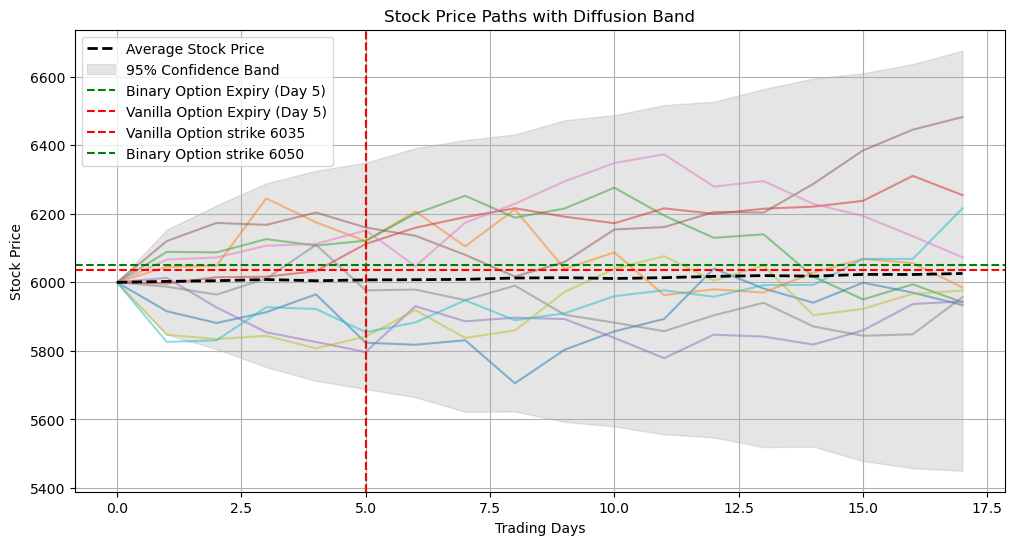

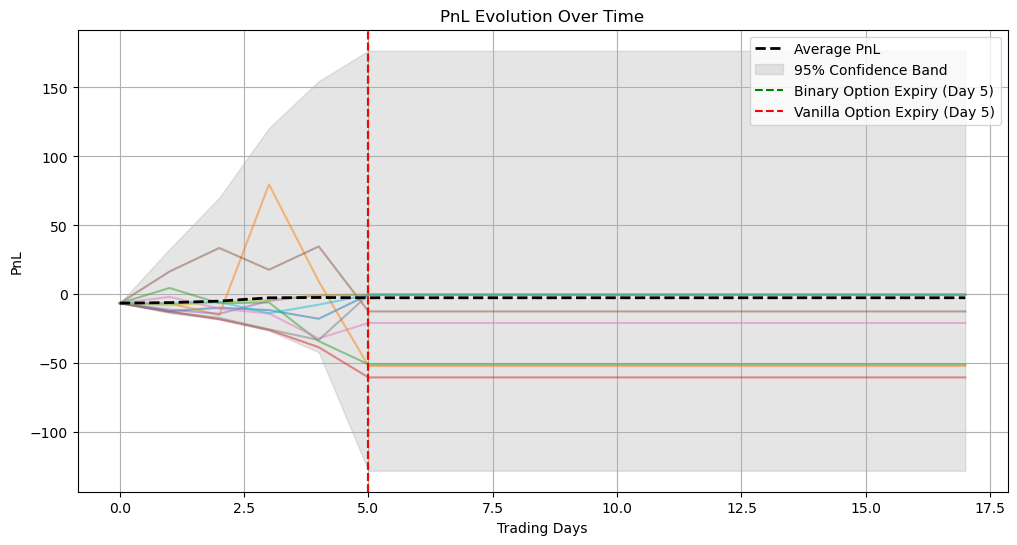

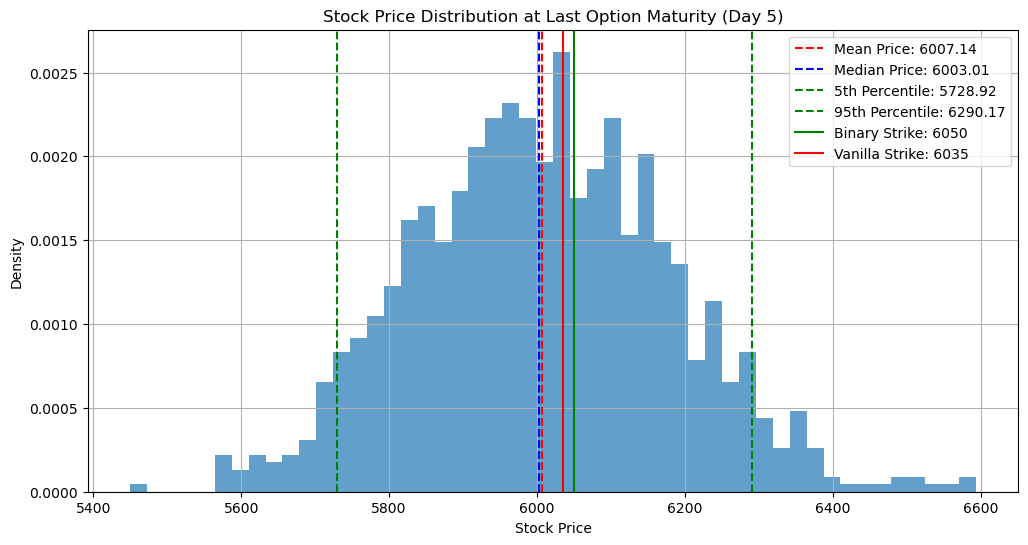

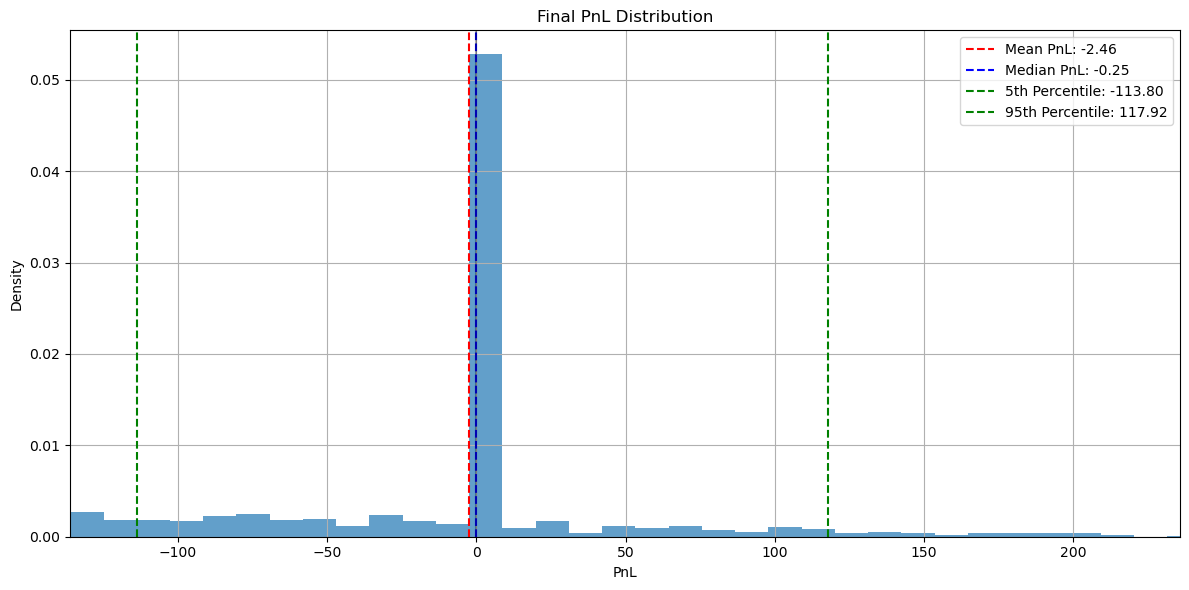

Max loss: -136.1385032924003
Max win: 420.99531613457987


In [185]:
plot_mc_results(mc_results)

print(f"Max loss: {mc_results['final_pnl'].min()}")
print(f"Max win: {mc_results['final_pnl'].max()}")

# This is far from risk free!

In [187]:
def analyze_pnl_distribution(mc_results, T_Binary, T_Vanilla, T_future):
    # Extract data from mc_results
    pnl_over_time = mc_results['pnl_over_time']
    days = mc_results['days']
    trading_days_per_year = 252
    
    # Key dates in day indices
    binary_expiry_idx = int(T_Binary * trading_days_per_year)
    vanilla_expiry_idx = int(T_Vanilla * trading_days_per_year)
    
    # Calculate metrics over time
    metrics_over_time = {
        'mean': np.mean(pnl_over_time, axis=0),
        'median': np.median(pnl_over_time, axis=0),
        'std': np.std(pnl_over_time, axis=0),
        'skewness': stats.skew(pnl_over_time, axis=0),
        'var_95': -np.percentile(pnl_over_time, 5, axis=0),  # 95% VaR
        'cvar_95': -np.mean(np.where(pnl_over_time <= np.percentile(pnl_over_time, 5, axis=0, keepdims=True), 
                                     pnl_over_time, np.nan), axis=0),  # 95% CVaR
        'positive_prob': np.mean(pnl_over_time >= -0.5, axis=0)  # Probability of positive PnL (use -0.5 to avoid small nummerical error)
    }
    
    return {
        'metrics_over_time': metrics_over_time,
        'days': days,
        'binary_expiry_day': binary_expiry_idx,
        'vanilla_expiry_day': vanilla_expiry_idx
    }

def visualize_pnl_analysis(mc_results, analysis_results, title="PnL Distribution Analysis"):
    days = mc_results['days']
    binary_expiry_day = analysis_results['binary_expiry_day']
    vanilla_expiry_day = analysis_results['vanilla_expiry_day']
    
    # Create figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle(title, fontsize=16)
    
    # Plot 1: PnL evolution (mean, std, skewness)
    ax = axes[0]
    ax.plot(days, analysis_results['metrics_over_time']['mean'], 'r-', label='Mean PnL')
    ax.plot(days, analysis_results['metrics_over_time']['median'], 'b-', label='Median PnL')
    ax.fill_between(days, 
                    mc_results['percentile_low_time'], 
                    mc_results['percentile_high_time'],
                    alpha=0.2, color='blue', label='95% Confidence Band')
    ax2 = ax.twinx()
    ax2.plot(days, analysis_results['metrics_over_time']['skewness'],color = 'grey', linestyle = '-', label='Skewness')
    
    # Add vertical lines for option expiries
    ax.axvline(x=binary_expiry_day, color='g', linestyle=':', label='Binary Expiry')
    ax.axvline(x=vanilla_expiry_day, color='r', linestyle=':', label='Vanilla Expiry')
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Add legends and labels
    ax.set_title('PnL Evolution')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('PnL')
    ax.legend(loc='upper left')
    ax2.set_ylabel('Skewness')
    ax2.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Risk metrics evolution
    ax = axes[1]
    ax.plot(days, analysis_results['metrics_over_time']['var_95'], 'r-', label='95% VaR')
    ax.plot(days, analysis_results['metrics_over_time']['cvar_95'], 'm--', label='95% CVaR')
    ax.plot(days, analysis_results['metrics_over_time']['std'], 'g-.', label='Std Deviation')
    
    # Add vertical lines for option expiries
    ax.axvline(x=binary_expiry_day, color='g', linestyle=':', label='Binary Expiry')
    ax.axvline(x=vanilla_expiry_day, color='r', linestyle=':', label='Vanilla Expiry')
    
    # Add labels and legend
    ax.set_title('Risk Metrics Evolution')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Risk Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Probability of positive PnL
    ax = axes[2]
    ax.plot(days, analysis_results['metrics_over_time']['positive_prob'] * 100, 'b-')
    
    # Add vertical lines for option expiries
    ax.axvline(x=binary_expiry_day, color='g', linestyle=':', label='Binary Expiry')
    ax.axvline(x=vanilla_expiry_day, color='r', linestyle=':', label='Vanilla Expiry')
    ax.axhline(y=50, color='k', linestyle='--', alpha=0.3)
    
    # Add labels
    ax.set_title('Probability of Positive PnL (%)')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Probability (%)')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

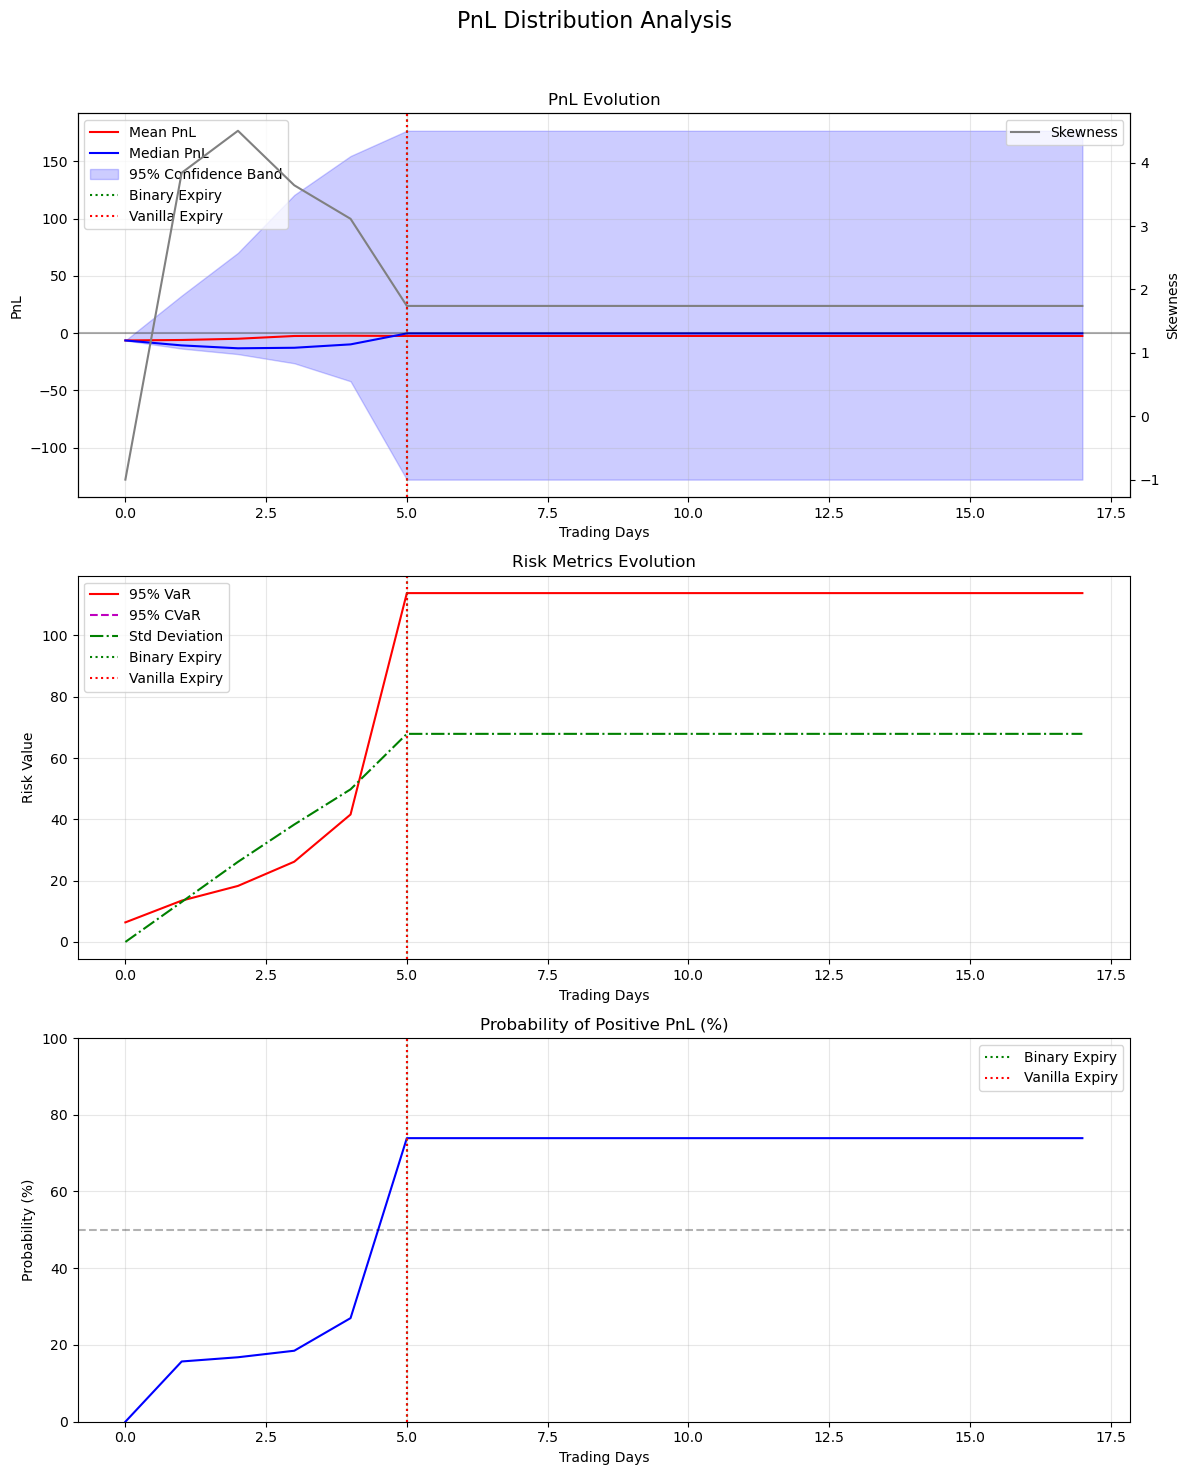

In [189]:
analysis_results = analyze_pnl_distribution(mc_results, T_Binary, T_Vanilla, T_future)

visualize_pnl_analysis(mc_results, analysis_results)

In [191]:
def animate_pnl_evolution(mc_results, title="PnL Distribution Evolution", fps=10, dpi=100, save_path=None):
    # Extract required data
    pnl_over_time = mc_results['pnl_over_time']
    days = mc_results['days']
    
    # Parameters for the animation
    K_Binary = mc_results['parameters']['K_Binary']
    K_Vanilla = mc_results['parameters']['K_Vanilla']
    T_Binary = mc_results['parameters']['T_Binary']
    T_Vanilla = mc_results['parameters']['T_Vanilla']
    
    # Convert to days
    T_Binary_day = int(T_Binary * 252)
    T_Vanilla_day = int(T_Vanilla * 252)
    
    # Calculate PnL statistics over time
    mean_pnl = np.mean(pnl_over_time, axis=0)
    median_pnl = np.median(pnl_over_time, axis=0)
    percentile_5 = np.percentile(pnl_over_time, 5, axis=0)
    percentile_95 = np.percentile(pnl_over_time, 95, axis=0)
    
    # Find global min/max for consistent y-axis limits
    global_min = percentile_5.min() * 1.1  # Add some margin
    global_max = percentile_95.max() * 1.1
    
    # Initialize the figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=16)
    
    # Left plot: Histogram at current time step
    hist_values, hist_bins = np.histogram(pnl_over_time[:, 0], bins=50, density=True, 
                                       range=(global_min, global_max))
    bar_container = ax1.bar(hist_bins[:-1], hist_values, width=np.diff(hist_bins), alpha=0.7, 
                          align='edge', color='skyblue', edgecolor='blue')
    
    # Line for mean, median, and percentiles
    mean_line = ax1.axvline([mean_pnl[0]], color='r', linestyle='--', label=f'Mean: {mean_pnl[0]:.2f}')
    median_line = ax1.axvline([median_pnl[0]], color='b', linestyle='--', label=f'Median: {median_pnl[0]:.2f}')
    p5_line = ax1.axvline([percentile_5[0]], color='g', linestyle='--', label=f'5%: {percentile_5[0]:.2f}')
    p95_line = ax1.axvline([percentile_95[0]], color='g', linestyle='--', label=f'95%: {percentile_95[0]:.2f}')
    zero_line = ax1.axvline(0, color='k', linestyle='-', alpha=0.3)
    
    # Create a text element for the day information
    day_text = ax1.text(0.05, 0.95, f'Day: {days[0]}', transform=ax1.transAxes, fontsize=12,
                      bbox=dict(facecolor='white', alpha=0.7))
    
    # Set up histogram plot
    ax1.set_title('PnL Distribution')
    ax1.set_xlabel('PnL')
    ax1.set_ylabel('Density')
    ax1.set_xlim(global_min, global_max)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Right plot: Evolution of distribution statistics over time
    x_data = days[:1]  # Start with just the first day
    
    # Create lines for the right plot
    mean_plot, = ax2.plot(x_data, mean_pnl[:1], 'r-', label='Mean PnL')
    median_plot, = ax2.plot(x_data, median_pnl[:1], 'b--', label='Median PnL')
    p5_plot, = ax2.plot(x_data, percentile_5[:1], 'g-.', label='5th Percentile')
    p95_plot, = ax2.plot(x_data, percentile_95[:1], 'g-.', label='95th Percentile')
    
    # Create filled region for confidence interval
    confidence_fill = ax2.fill_between(x_data, percentile_5[:1], percentile_95[:1], 
                                     alpha=0.2, color='gray', label='90% Confidence')
    
    # Vertical lines for option expiry
    if T_Binary_day <= max(days):
        binary_line = ax2.axvline(x=T_Binary_day, color='g', linestyle=':', label=f'Binary Expiry')
    
    if T_Vanilla_day <= max(days):
        vanilla_line = ax2.axvline(x=T_Vanilla_day, color='r', linestyle=':', label=f'Vanilla Expiry')
    
    # Set up the evolution plot
    ax2.set_title('PnL Statistics Evolution')
    ax2.set_xlabel('Trading Days')
    ax2.set_ylabel('PnL')
    ax2.set_xlim(0, max(days))
    ax2.set_ylim(global_min, global_max)
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Create a vertical line to track current day in evolution plot
    current_day_line = ax2.axvline(x=days[0], color='k', linestyle='-', linewidth=1)
    
    # Store the confidence fill to update it
    confidence_fill_artists = [confidence_fill]
    
    def init():
        # This function will be called to initialize the animation
        return bar_container.patches + [mean_line, median_line, p5_line, p95_line, day_text, 
                mean_plot, median_plot, p5_plot, p95_plot, current_day_line]
    
    def update(frame):
        # Update histogram
        hist_values, hist_bins = np.histogram(pnl_over_time[:, frame], bins=50, density=True, 
                                           range=(global_min, global_max))
        
        # Update the bar heights
        for bar, h in zip(bar_container, hist_values):
            bar.set_height(h)
        
        # Update the lines (fix the deprecation warnings by using arrays)
        mean_line.set_xdata([mean_pnl[frame]])
        median_line.set_xdata([median_pnl[frame]])
        p5_line.set_xdata([percentile_5[frame]])
        p95_line.set_xdata([percentile_95[frame]])
        
        # Update text
        day_text.set_text(f'Day: {days[frame]}')
        
        # Update label text
        ax1.legend([mean_line, median_line, p5_line, p95_line], 
                 [f'Mean: {mean_pnl[frame]:.2f}', 
                  f'Median: {median_pnl[frame]:.2f}',
                  f'5%: {percentile_5[frame]:.2f}',
                  f'95%: {percentile_95[frame]:.2f}'])
        
        # Update evolution plot
        new_x = days[:frame+1]
        mean_plot.set_data(new_x, mean_pnl[:frame+1])
        median_plot.set_data(new_x, median_pnl[:frame+1])
        p5_plot.set_data(new_x, percentile_5[:frame+1])
        p95_plot.set_data(new_x, percentile_95[:frame+1])
        
        # Update confidence band (fix the collections.clear() error)
        for artist in confidence_fill_artists:
            artist.remove()
        confidence_fill_artists[0] = ax2.fill_between(new_x, percentile_5[:frame+1], percentile_95[:frame+1], 
                                                   alpha=0.2, color='gray')
        
        # Update current day line
        current_day_line.set_xdata([days[frame]])
        
        return bar_container.patches + [mean_line, median_line, p5_line, p95_line, day_text, 
                mean_plot, median_plot, p5_plot, p95_plot, current_day_line, confidence_fill_artists[0]]
    
    # Create animation with init_func to prevent deletion warning
    ani = animation.FuncAnimation(fig, update, frames=len(days), 
                                init_func=init, blit=True, 
                                interval=1000/fps, repeat=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save animation if path is provided
    if save_path:
        # Need to keep the figure open during save
        plt.rcParams['animation.html'] = 'jshtml'  # For notebook display
        
        try:
            # Determine the format from the file extension
            if save_path.endswith('.mp4'):
                writer = animation.FFMpegWriter(fps=fps)
            elif save_path.endswith('.gif'):
                writer = animation.PillowWriter(fps=fps)
            else:
                # Default to mp4
                save_path += '.mp4'
                writer = animation.FFMpegWriter(fps=fps)
                
            ani.save(save_path, writer=writer, dpi=dpi)
            print(f"Animation saved to {save_path}")
        except Exception as e:
            print(f"Failed to save animation: {e}")
            print("Try installing ffmpeg or pillow depending on your desired output format.")
    
    # Don't close the figure, we need it for display
    return ani  # Return the animation object

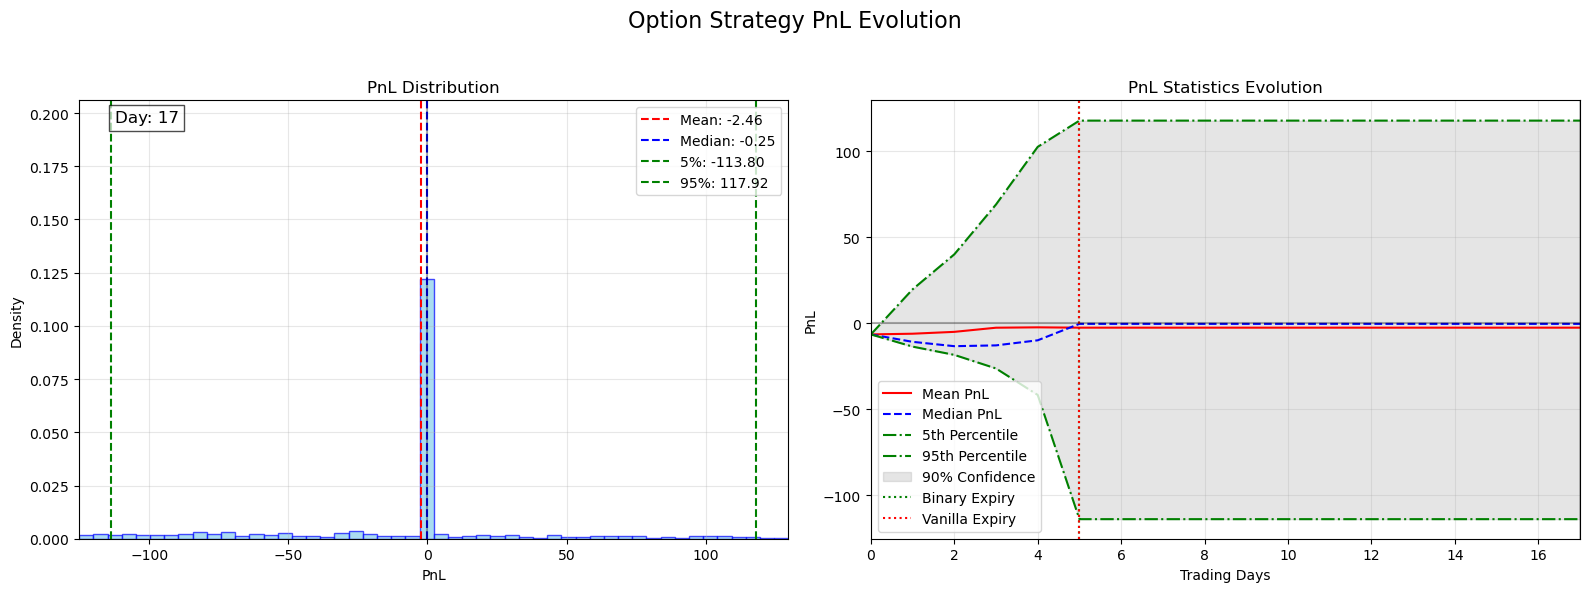

In [193]:
ani = animate_pnl_evolution(mc_results, title="Option Strategy PnL Evolution")
HTML(ani.to_jshtml())